# Ames Housing Data model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('datasets/train.csv', index_col = 'PID')
kaggle_test = pd.read_csv('datasets/test.csv', index_col = 'PID')

In [3]:
df.shape, kaggle_test.shape

((2051, 80), (878, 79))

In [4]:
df.head(3)

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
PID,,,,,,,,,,,,,,,,,,,,,
533352170,109,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
531379050,544,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
535304180,153,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


# Purpose:

The primary purpose of this exercise is to develop a regression model that accurately predicts home values for homes at sale in the Ames Iowa Housing dataset consistent with the Kaggle Rules- https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge.

By definition this will be looking at linear regression, lasso and ridge models with the goal of getting the Root Mean Squared Error (RMSE) as close to 0 as possible for the test data provided on Kaggle.

## Preliminary EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 533352170 to 527162130
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Frontage     1721 non-null   float64
 4   Lot Area         2051 non-null   int64  
 5   Street           2051 non-null   object 
 6   Alley            140 non-null    object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  O

In [6]:
df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending = False).head(10)

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


In [7]:
df.drop(df[df['Gr Liv Area'] > 4000].index, inplace = True)  
# jse.amstat.org recommends dropping any homes with greater 'GR Liv Area' greater than 4k sqft
# as they are outliers.
df.drop(columns = 'Id', inplace = True)
kaggle_test.drop(columns = 'Id', inplace = True)

__Feature Engineering__

This segment follows a workflow that loops through Iterate - Examine based on 2 factors:
    1. Correllation
    2. Variance Inflation Factor

and is later revisited after modeling

In [8]:
# df['has_pool'] = df['Pool Area'].map(has_pool)

# df['has_porch'] = np.where((df['Wood Deck SF'] > 0) | (df['Open Porch SF'] > 0) |
#                            (df['Screen Porch'] > 0) | (df['Enclosed Porch'] > 0) |
#                            (df['3Ssn Porch'] > 0) , 1, 0
#                           )

# adding porch and pool indicator dramatically decreased model accuracy

In [9]:
df.groupby('Mas Vnr Type')['SalePrice'].mean().sort_values(ascending = False)

Mas Vnr Type
Stone      264820.602410
BrkFace    212161.436508
None       153679.275862
BrkCmn     144515.692308
Name: SalePrice, dtype: float64

In [10]:
df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending = False)

Neighborhood
StoneBr    329675.736842
NridgHt    322831.352459
NoRidge    316294.125000
GrnHill    280000.000000
Veenker    253570.588235
Timber     241051.354167
Somerst    227183.900000
ClearCr    217490.074074
Crawfor    205901.211268
CollgCr    202497.216667
Blmngtn    200417.681818
NWAmes     194619.022989
Gilbert    189228.387931
Greens     188666.666667
SawyerW    187760.160920
Mitchel    167656.707317
NAmes      145905.816129
Blueste    144566.666667
NPkVill    140476.470588
Sawyer     137181.909910
Landmrk    137000.000000
SWISU      134758.875000
Edwards    129905.787234
BrkSide    127022.697368
OldTown    125276.300613
BrDale     103371.052632
IDOTRR     101103.188406
MeadowV    100231.250000
Name: SalePrice, dtype: float64

In [11]:
df.groupby('Roof Style')['SalePrice'].mean().sort_values(ascending = False)

Roof Style
Hip        224632.182278
Shed       208666.666667
Flat       191613.076923
Gable      171264.253243
Mansard    152642.857143
Gambrel    138208.333333
Name: SalePrice, dtype: float64

The three above groupings are all showing significant differences between categories.  I'll dummify them.

In [12]:
df = pd.get_dummies(df, columns = ["Neighborhood", "Roof Style", 'Mas Vnr Type', 'Condition 1', 'Condition 2'], drop_first= True)

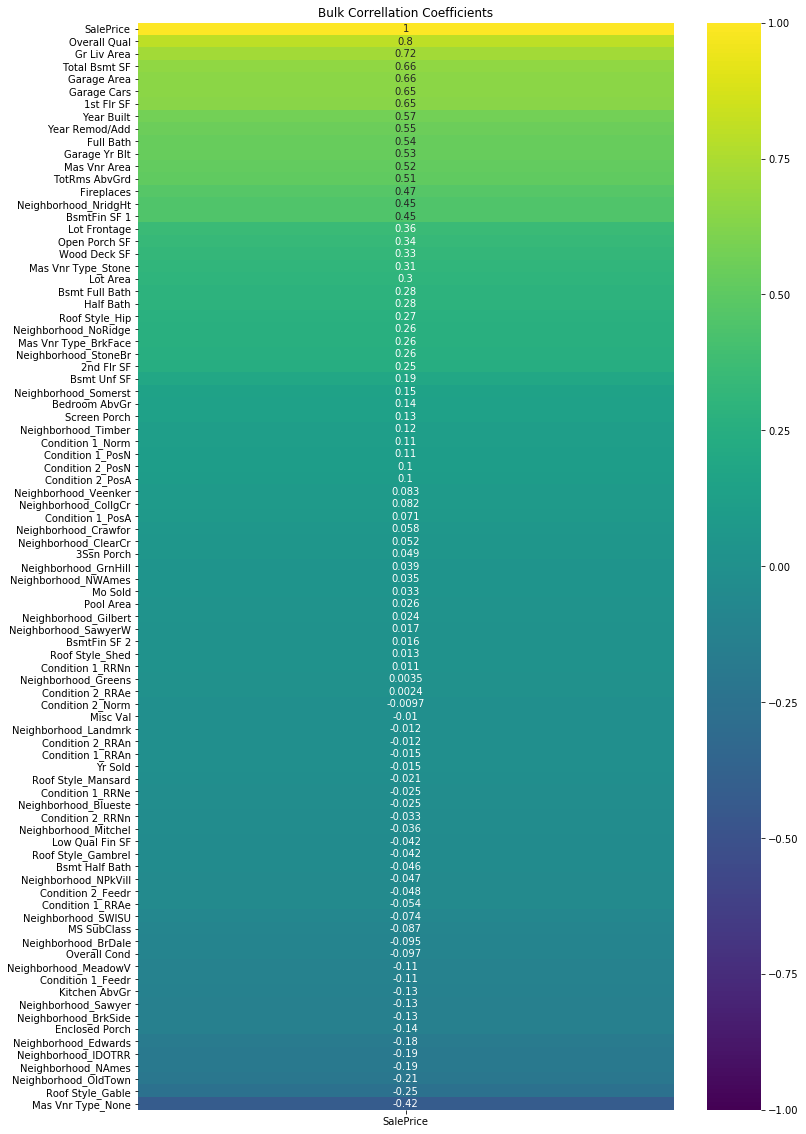

In [13]:
plt.figure(figsize = (12, 20))
sns.heatmap(df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending = False),
           vmin = -1,
           vmax = 1,
           cmap = 'viridis',
           annot = True
           );
plt.title('Bulk Correllation Coefficients')
plt.savefig('./imgs/BulkCorrelationHeatmap.png')

From the above correllation heatmap we can see the spectrum of effects our various variables have on the sale price.
I'll narrow it down somewhat to only correlations above an absolute value of 0.4 and our dummy columns

In [14]:
explanatory_vars = df.drop(columns = ['BsmtFin SF 1', 'Screen Porch',
                                      'Enclosed Porch', 'Kitchen AbvGr', 'Lot Frontage',
                                      'Overall Cond', 'Garage Yr Blt', 'Year Remod/Add',
                                      'Paved Drive', 'Sale Type', 'MS Zoning', 
                                      'Functional', 'Heating QC', 'House Style', 
                                      'Lot Frontage', 'MS SubClass', 'Bsmt Half Bath',
                                      'Low Qual Fin SF', 'Yr Sold', 'Misc Val', 
                                      'BsmtFin SF 2', 'Pool Area', 'Mo Sold', '3Ssn Porch', 
                                      'Bedroom AbvGr', 'Bsmt Unf SF', '2nd Flr SF',
                                      'Half Bath', 'Bsmt Full Bath', "Lot Area",
                                      'Wood Deck SF', 'Open Porch SF', 'Street',
                                      'Alley', 'Lot Shape', 'Land Contour',
                                      'Utilities', 'Lot Config', 'Land Slope',
                                      'Bldg Type', 'House Style', 
                                      'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
                                      'Exter Qual', 'Exter Cond',
                                      'Foundation', 'Bsmt Qual', 'Bsmt Cond',
                                      'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                                      'Heating', 'Electrical', 'Kitchen Qual', 
                                      "Fireplace Qu", 'Garage Type', 'Garage Finish',
                                      'Garage Qual', 'Garage Cond', 'Paved Drive',
                                      'Pool QC', 'Fence', 'Misc Feature', 
                                      'Central Air'
                                     ]).columns


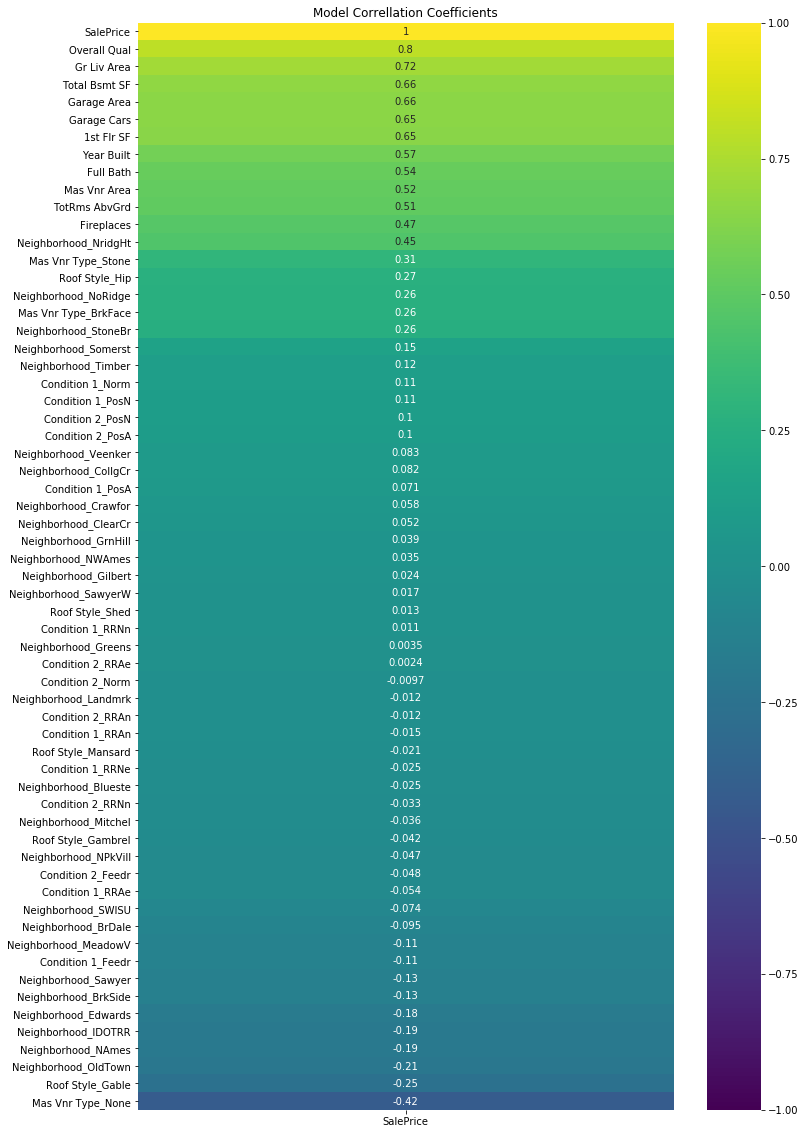

In [35]:
plt.figure(figsize = (12, 20))
sns.heatmap(df[explanatory_vars].corr()[['SalePrice']].sort_values(by='SalePrice', ascending = False),
           vmin = -1,
           vmax = 1,
           cmap = 'viridis',
           annot = True
           );
plt.title('Model Correllation Coefficients')
plt.savefig('./imgs/ModelCorrelationHeatmap.png');

In [16]:
df[explanatory_vars].isna().sum()

Overall Qual         0
Year Built           0
Mas Vnr Area        22
Total Bsmt SF        1
1st Flr SF           0
                    ..
Condition 2_PosA     0
Condition 2_PosN     0
Condition 2_RRAe     0
Condition 2_RRAn     0
Condition 2_RRNn     0
Length: 62, dtype: int64

In [17]:
model = df[explanatory_vars].copy()

From this I'm seeing that where Garage Year Built is blank we have a garage with no area-- AKA No garage. Similar for Masonry Veneer Type. Filling NA's with 0 to capture 'no garage, no masonry veneer, or no basement' as 0,

In [18]:
model.fillna(0, inplace = True)

In [19]:
variables = list(range(model.shape[1]))
columns = pd.Series(model.columns, name = 'Col_name')
vif = pd.Series([variance_inflation_factor(model.iloc[:, variables].values, ix) for ix in variables], name = 'VIF')
vif_df = pd.concat([columns, vif], axis = 1)
vif_df = vif_df.sort_values('VIF', ascending = False)
# Using a DataFrame to organize and better display VIF data inspired by 
# Mahdi Shadkam-Farrokhi's Quiz 02 review.
vif_df.head(5) 

,Col_name,VIF
1,Year Built,845.350819
56,Condition 2_Norm,427.864443
39,Roof Style_Gable,138.980670
0,Overall Qual,73.900817
5,Gr Liv Area,70.373228


the three biggest VIF scores are Year Remod/Add, Year Built and Garage Yr Blt.
This tells me that year remodeled and year built are directly connected and
I only want to include one of the three in my model.  Removing Year Remod/Add and Garage Yr Blt.

In [20]:
model.head(3)

,Overall Qual,Year Built,Mas Vnr Area,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,...,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn
PID,,,,,,,,,,,,,,,,,,,,,
533352170,6,1976,289.0,725.0,725,1479,2,6,0,2.0,...,0,0,0,0,1,0,0,0,0,0
531379050,7,1996,132.0,913.0,913,2122,2,8,1,2.0,...,0,0,0,0,1,0,0,0,0,0
535304180,5,1953,0.0,1057.0,1057,1057,1,5,0,1.0,...,0,0,0,0,1,0,0,0,0,0


## Train-Test-Split

In [21]:
X = model.drop(columns = 'SalePrice')
y = model['SalePrice']

In [22]:
ss = StandardScaler()
ss.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [24]:
X_train.shape[0], X_test.shape[0]

(1536, 513)

In [25]:
y_train.shape[0], y_test.shape[0]

(1536, 513)

## Model

##### Linear Regression Model

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8682300417034426, 0.8727959467703807)

In [28]:
cross_val_score(lr, X_train, y_train)

array([0.84278198, 0.85358254, 0.84225921, 0.86079503, 0.83568513])

## Evaluate Model

In [29]:
y_test_preds = lr.predict(X_test)

In [30]:
mean_squared_error(y_test, y_test_preds) ** 0.5

28358.39553360141

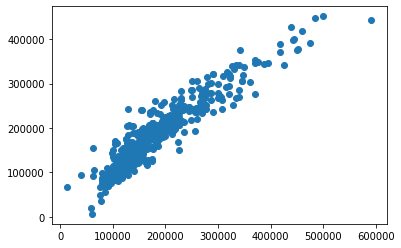

In [31]:
plt.scatter(y_test, y_test_preds)

In [32]:
test_residuals = y_test_preds - y_test

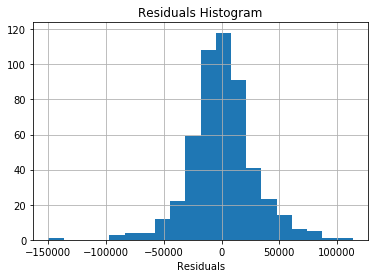

In [33]:
test_residuals.hist(bins = 20)
plt.xlabel('Residuals')
plt.title('Residuals Histogram');

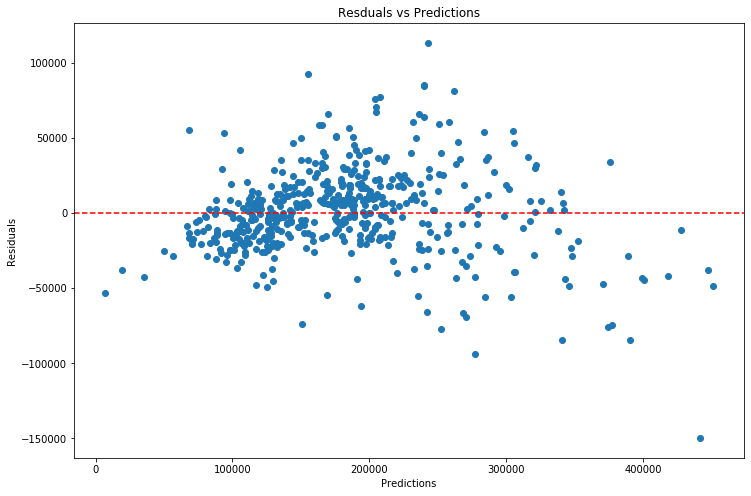

In [34]:
plt.figure(figsize = (12, 8))
plt.scatter(y_test_preds, test_residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(c = 'red', ls = 'dashed')
plt.title('Resduals vs Predictions');